# Tweet Sentiment Analysis

## Overview

SXSW is a annual festival held in Austin, TX, encompassing a wide range of topics from film / music to text conferences. At the 2013 tech conference, tweets with the hashtag #SXSW directed at Google or Apple were aggregregated, and attendees were asked to classify the tweets as Positive, Negative, or Neutral with regards to the respective brands. This manual classification can be used to train models to predict sentiment based on the contents of the tweets.

## Business Problem

The Google marketing department has asked us to use the tweets from this conference to build a model that can accurately predict tweet sentiment that can be used at future conferences or for tweets directed at Google and its competitors more generally. They want to use the model to compare performance across years at SXSW and similar conferences to see if their product strategy is driving positive engagement.

Historically, collecting consumer reviews has been a tedious process. Online reviews are useful, but tend to have a bias towards negative reviews. If someone is perfectly fine with a product, they're not as likely to leave a positive review as someone who has had a bad experience. Analyzing tweets is a potential way to bridge this gap, by providing a more unfiltered view into brand sentiment.


## Deliverable 

The final deliverable is the model itself. Google wants to be able to accurately track brand sentiment over time. The primary metric that we care about is model accuracy on the testing set. In this context a false positive would be classifying a tweet as positive, when it's in fact neutral or negative. A false negative is saying that a tweet is neutral / negative when it's indeed positive. 

Google has a slight bias towards minimizing false positives. I.e., they would prefer to be conservative and be really sure that a tweet is positive. Overall, however, they're more concerned with model accuracy.

## Data Review

- The data contains ~9,000 tweets from the 2013 SXSW conference. Every tweet has #SXSW or #sxsw as an identifier.
- The data contains the product/company the tweet was directed at. There are a lot of nulls here. This will not be used in modeling but rather for EDA and to interprate the results
- The target variable is the tweet sentiment. This has been manually crowdsourced into four categories:
    - Positive emotion
    - Negative emotion
    - No emotion (neutral)
    - I can't tell
- For simplicity, we will make this a binary classification problem. We will be testing whether a tweet is positive or not. Therefore, Negative, No Emotion, and I Can't Tell will be grouped into the other bucket.
- There is a fairly sizeable class imbalance with this approach: only 1/3 of the tweets are "positive"

In [196]:
# Standard Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Set style
plt.style.use('seaborn')

In [99]:
# NLP imports

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import string
import re

# Wordcloud
from wordcloud import WordCloud

In [201]:
# Processing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import plot_confusion_matrix

# Modeling
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [198]:
# Utility import

from util import evaluate_model

In [5]:
# Download stopwords

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeffreymarvel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Set Pandas options
pd.set_option('display.max_colwidth', None)

In [7]:
# Import data

tweet_df = pd.read_csv('./../../Data/judge-1377884607_tweet_product_company.csv', encoding = 'unicode_escape')

In [8]:
# Change column names to something more readable

tweet_df.columns = ['tweet', 'product/company', 'emotion']

In [9]:
tweet_df.head(5)

,tweet,product/company,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


In [10]:
# Explore distribution of target variable. 60% are netural, 33% are positive, and only 6% are negative

tweet_df['emotion'].value_counts(normalize = True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: emotion, dtype: float64

In [11]:
# Explore nulls in tweets. There is one blank tweet.

tweet_df.isna().sum()

tweet                 1
product/company    5802
emotion               0
dtype: int64

In [12]:
# Check for duplicates
# There are 27 duplicate tweets

tweet_df.duplicated('tweet').sum()

27

In [13]:
# Explore nulls for where product / company is null
# Most of the nulls for product / company are neutral

no_brand = tweet_df[tweet_df['product/company'].isna()]

no_brand['emotion'].value_counts()

No emotion toward brand or product    5298
Positive emotion                       306
I can't tell                           147
Negative emotion                        51
Name: emotion, dtype: int64

In [14]:
# Almost all of the "can't tell" emotions do not have a product associated with them.
# Plan is to drop these rows unless we can fill in some of the values with Text Blob

cant_tell = tweet_df[tweet_df['emotion'] == "I can't tell"]

cant_tell['product/company'].isna().sum() / cant_tell.shape[0]

0.9423076923076923

In [15]:
# Determine value counts of brands

brand_list = list(tweet_df['product/company'].value_counts().index)

brand_list

['iPad',
 'Apple',
 'iPad or iPhone App',
 'Google',
 'iPhone',
 'Other Google product or service',
 'Android App',
 'Android',
 'Other Apple product or service']

## Data Preparation

- No brainer steps: the duplicate tweets and the one null tweet are dropped from the dataset
- Brand: product/company will be filled in based on a search of keywords in the tweet. If it mentions only either Apple or Google, the brand will be filled it accordingly. If it mentions both, it will be labeled as "both". Otherwise we'll fill in with "unknown". This will not be used for modeling but rather EDA and visualizations.
- Tweet cleaning: this is the bulk of the work and will be described in further detail below.

In [16]:
# Drop the single null tweet

df_clean = tweet_df.dropna(subset=['tweet'])

In [17]:
# Drop the duplicate tweets

df_clean = df_clean.drop_duplicates(subset='tweet')

In [18]:
# Define function to fill in missing brands

def fill_brand(product, tweet):
    
    '''
    Fill brand takes in two columns as inputs: the existing product tag and the tweet.
    Function is intended to create a new 'brand' column of the tweet dataframe.
    Where the product field is already filled in, products are mappe to Google or Apple.
    For other rows, tweets are searched for any of the Google or Apple keywords described below.
    If only Apple keywords exist, fill in Apple. Vice Versa for Google. If both exist, return Both.
    
    Returns final brand designation.
    
    '''
    
    apple_keywords = ['Apple', 'iPhone', 'iPad', 'iTunes', 'Other Apple product or service',
                     'iPad or iPhone App', 'apple', 'iphone', 'ipad', 'itunes']
    google_keywords = ['Google', 'google', 'Android', 'android', 'Other Google product or service',
                      'Android App']
    
    apple_mentions = 0
    google_mentions = 0
    
    # Check for whether tweet mentioned any keywords, first by tokenizing, making lowercase, and 
    # removing punctuation on the string
    for word in tweet.split(' '):
        if word.translate(str.maketrans('', '', string.punctuation)).lower() in apple_keywords:
            apple_mentions += 1
        elif word.translate(str.maketrans('', '', string.punctuation)).lower() in google_keywords:
            google_mentions += 1
    
    # Fill in with following logic: if product/company is already filled in, just use that value
    # Otherwise, if tweet only mentions Apple products, tag as Apple
    # If tweet only mentions Google products, tag as Google
    # If it mentions both, tag as both, otherwise "Unknown"
    if product in apple_keywords:
        brand = 'Apple'
    elif product in google_keywords:
        brand = 'Google'
    elif (apple_mentions > 0) & (not google_mentions):
        brand = 'Apple'
    elif (not apple_mentions) & (google_mentions > 0):
        brand = 'Google'
    elif (apple_mentions > 0) & (google_mentions > 0):
        brand = 'Both'
    else:
        brand = 'Unknown'
    
    return brand

df_clean['brand'] = df_clean.apply(lambda row: fill_brand(row['product/company'], row['tweet']), axis=1)

In [19]:
# Apply the function to the new brand column

df_clean['brand'] = df_clean.apply(lambda row: fill_brand(row['product/company'], row['tweet']), axis=1)

In [20]:
# Display value counts for the brands
# Were able to reduce 5,800 null brands down to only 1,000 with this approach.

df_clean['brand'].value_counts()

Apple      5266
Google     2572
Unknown    1076
Both        151
Name: brand, dtype: int64

### Tweet cleaning

The following describes the steps taken to clean the tweets along with rationale
- Remove URLs. In tweets, URLs are compressed with a random assortment of numbers / digits. They have no predictive value.
- When tweets are scraped, sometimes the links don't render, instead appearing as {link} or [video]. These references should be removed.
- The symbol 'Ûª' appears in place of an apostrophe sometimes. These will be replaced.
- Remove hashtag symbols but keep the contents. We don't want to remove the hashtag contents as they may be important for making predictions.
- Remove @ mentions. Tweets from this conference are often tweeting at the same account. Will help reduce dimensionality of our data.
- Remove non-sensical symbols. It appears certain characters render weirdly when scraped. We did a count vectorizer to examine these symbols and created a list to strip all of them out of the tweets.
- Remove stop words. We stuck with the standard English stopword list and added the following:
    - SXSW or sxsw: every tweet contains this by definition (it was how they were scraped). They hold no predictive value if every tweet has them and should be removed
    - Punctuation

In [248]:
df_clean['clean_tweet'] = df_clean['tweet']

In [249]:
# Remove hyperlinks
df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: re.sub(r'(http://[^"\s]+)|(@\w+)', '', x))
df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: re.sub(r'(https://[^"\s]+)|(@\w+)', '', x))
df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))

# Remove {link} and [video] references
df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: re.sub(r'{link}', '', x))
df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: re.sub(r'\[video\]', '', x))

# Replace these characters (which appear in place of an apostrophe)
df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: x.replace('Ûª', "'"))

# Remove hastag but keep the words
df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: re.sub(r'#', '', x))

# Remove @ handles
df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: x.replace('@', ''))

In [250]:
# Sanity check output

df_clean.head()

,tweet,product/company,emotion,brand,clean_tweet,sentiment,clean_tweet_stem,tokens,sentiment_type
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion,Apple,". I have a 3G iPhone. After 3 hrs tweeting at RISE_Austin, it was dead! I need to upgrade. Plugin stations at SXSW.",0,3g iphon 3 hrs tweet rise_austin dead need upgrad plugin station,"[wesley, 83, 3g, iphone, hrs, tweeting, rise_austin, dead, need, upgrade, plugin, stations]",Not Positive
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion,Apple,"Know about ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at SXSW",1,know awesom ipad iphon app like appreci design also they'r give free ts,"[jessedee, know, fludapp, awesome, ipad, iphone, app, likely, appreciate, design, also, they, re, giving, free, ts]",Positive
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion,Apple,Can not wait for iPad 2 also. They should sale them down at SXSW.,1,wait ipad 2 also sale,"[swonderlin, wait, ipad, also, sale]",Positive
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion,Apple,I hope this year's festival isn't as crashy as this year's iPhone app. sxsw,0,hope year festiv crashi year iphon app,"[hope, year, festival, crashy, year, iphone, app]",Not Positive
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion,Google,"great stuff on Fri SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",1,great stuff fri marissa mayer googl tim o'reilli tech book confer matt mullenweg wordpress,"[sxtxstate, great, stuff, fri, marissa, mayer, google, tim, reilly, tech, books, conferences, matt, mullenweg, wordpress]",Positive


In [251]:
# Do a count vectorizer to check for weird symbols that should be removed

ct_vectorizer = CountVectorizer()
ct_vectorizer.fit(df_clean['clean_tweet'])
clean_tweet_vec = ct_vectorizer.transform(df_clean['clean_tweet'])

ct_vect_df = pd.DataFrame(clean_tweet_vec.toarray(),
                          columns=ct_vectorizer.get_feature_names())

ct_vect_cols = list(ct_vect_df.columns)

# ct_vect_cols[-26:]

In [252]:
# Define function to remove symbols that appear at the bottom of the count vectorizer

def remove_symbols(text):
    symbols_to_remove = ['ª¼', 'ªè', '¼¼', '¾û', 'á¾_î¾ð', 'áî', 'â_', 'ââ', 'âã', 'ã_', 'ä_', 'ä___ü', 'äá',
                         'å_', 'åç', 'åè', 'çü', 'èï', 'ìù', 'ïà', 'ïî', 'ïö', 'ð_', 'ðü', 'öý', 'ù_¾', 'û_',
                         'û_a', 'û_', 'û¼', 'û', 'ûï', 'ûò', 'ü_', 'ÛÏ', 'Û', 'ó', 'ò', 'ù_', 'â']
    
    clean_text = text
    
    for symbol in symbols_to_remove:
        clean_text = clean_text.replace(symbol, '')
    
    return clean_text

In [253]:
# Remove symbols

df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: remove_symbols(x))

In [254]:
# Define function to remove stop words and punctuation

def remove_stop(text):
    
    # Instantiate a tweet tokenizer
    tweet_tokenizer = TweetTokenizer(preserve_case=False, reduce_len=False, strip_handles=False)
    
    clean_text = text
    
    # Tokenize the sweets
    tweet_token = tweet_tokenizer.tokenize(clean_text)
    
    # Remove stop words and punctuation
    stop_words = stopwords.words('english')
    stop_words += list(string.punctuation)
    stop_words += ['SXSW', 'sxsw']
    
    stop_tweet_token = [word for word in tweet_token if word not in stop_words]
    stop_tweet_token = [word.lower() for word in stop_tweet_token]
    
    clean_text = " ".join(stop_tweet_token)
    
    return clean_text

In [255]:
# Remove stop words and punctuation

df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: remove_stop(x))

In [367]:
# Sanity check output

df_clean.head()

,tweet,product/company,emotion,brand,clean_tweet,sentiment,clean_tweet_stem,tokens,sentiment_type,original_length,new_length
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion,Apple,3g iphone 3 hrs tweeting rise_austin dead need upgrade plugin stations,0,3g iphon 3 hrs tweet rise_austin dead need upgrad plugin station,"[3g, iphone, hrs, tweeting, rise_austin, dead, need, upgrade, plugin, stations]",Not Positive,127,70
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion,Apple,know awesome ipad iphone app likely appreciate design also they're giving free ts,1,know awesom ipad iphon app like appreci design also they'r give free ts,"[know, awesome, ipad, iphone, app, likely, appreciate, design, also, they, re, giving, free, ts]",Positive,139,81
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion,Apple,wait ipad 2 also sale,1,wait ipad 2 also sale,"[wait, ipad, also, sale]",Positive,79,21
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion,Apple,hope year's festival crashy year's iphone app,0,hope year festiv crashi year iphon app,"[hope, year, festival, crashy, year, iphone, app]",Not Positive,82,45
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion,Google,great stuff fri marissa mayer google tim o'reilly tech books conferences matt mullenweg wordpress,1,great stuff fri marissa mayer googl tim o'reilli tech book confer matt mullenweg wordpress,"[great, stuff, fri, marissa, mayer, google, tim, reilly, tech, books, conferences, matt, mullenweg, wordpress]",Positive,131,97


In [257]:
# Create a sentiment target and map it
# As described at the top, we will make this a binary classification, with Positive tweets as 1 and everything
# Else as 0

target_map = {'Positive emotion': 1,
              'No emotion toward brand or product': 0,
              'Negative emotion': 0,
              "I can't tell": 0}

# Map it
df_clean['sentiment'] = df_clean['emotion'].map(target_map)

## Data Exploration

- Now that we have reasonably clean data, we will do some summary statistics and other visualizations on the dataset

Things to do for data visualization / exploration
- Bar charts showing % of positive vs. not positive reviews by brand
- Examples of positive and negative tweets for Google
- Word clouds (one of each for all positve and all negative tweets)
- Other backup info: why should Google care about this.

In [258]:
# Tokenize the tweets to build the word clouds

def tokenize(tweet):
    
    tokenizer = RegexpTokenizer(pattern='(?u)\\b\\w\\w+\\b')
    
    tokens = tokenizer.tokenize(tweet)
    
    return tokens

df_clean['tokens'] = df_clean['clean_tweet'].apply(lambda x: tokenize(x))
token_list = df_clean['tokens'].sum()
freq_dist = FreqDist(token_list)

In [348]:
# Create dataframes of positive and "not positive" tweets

google_pos = df_clean[(df_clean['sentiment'] == 1) & (df_clean['brand'] == 'Google')]
google_neg = df_clean[(df_clean['sentiment'] == 0) & (df_clean['brand'] == 'Google')]

In [350]:
# Create freq_dist of pos / neg tweets

pos_token_list = google_pos['tokens'].sum()
neg_token_list = google_neg['tokens'].sum()

freq_dist_google_pos = FreqDist(pos_token_list)
freq_dist_google_neg = FreqDist(neg_token_list)

In [368]:
# See what % of the time circle appears in the pos and neg list

pos_circle_counter = 0
neg_circle_counter = 0

for word in pos_token_list:
    if word == 'circles':
        pos_circle_counter += 1
        
for word in neg_token_list:
    if word == 'circles':
        neg_circle_counter += 1
        
pos_circle_percent = pos_circle_counter / len(pos_token_list)
neg_circle_percent = neg_circle_counter / len(neg_token_list)

print(pos_circle_percent, neg_circle_percent)

0.014010507880910683 0.02898467871026755


<ipython-input-364-8ab8029dd671>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, fontsize=12);


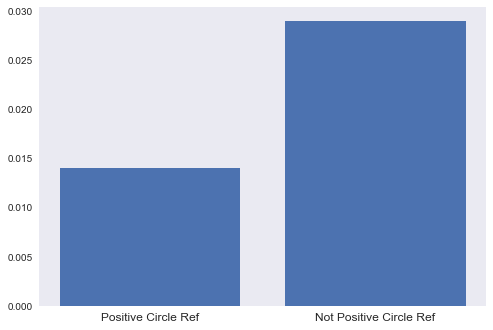

In [364]:
circle_ref = [pos_circle_percent, neg_circle_percent]
x = ['Positive Circle Ref', 'Not Positive Circle Ref']

fig, ax = plt.subplots()

ax.bar(x=x, height=circle_ref)
ax.grid(False)
ax.set_xticklabels(x, fontsize=12);

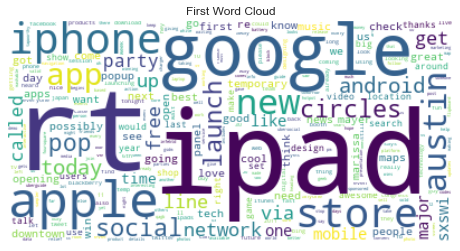

In [259]:
p_wc = WordCloud(background_color="white", max_words=500)
p_wc.generate_from_frequencies(freq_dist)

plt.figure(figsize=(8,8))
plt.imshow(p_wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('First Word Cloud')
plt.show()

In [ ]:
# Positive tweets only

df_positve = df_clean[df_clean['sentiment'] == 1]

pos_token_list = df_positive['tokens'].sum()

pos_freq_dist = FreqDist(pos_token_list)

In [191]:
def map_sentiment(sentiment):
    if sentiment:
        return 'Positive'
    else:
        return 'Not Positive'

df_clean['sentiment_type'] = df_clean['sentiment'].apply(lambda x: map_sentiment(x))

In [213]:
overall_vc = df_clean['sentiment_type'].value_counts(normalize=True)
apple_vc = df_clean[df_clean['brand'] == 'Apple']['sentiment_type'].value_counts(normalize=True)
google_vc = df_clean[df_clean['brand'] == 'Google']['sentiment_type'].value_counts(normalize=True)

In [216]:
brand_summary

,Not Positive,Positive
Overall,0.672587,0.327413
Google,0.682737,0.317263
Apple,0.597797,0.402203


<ipython-input-366-d0f879919882>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=12)


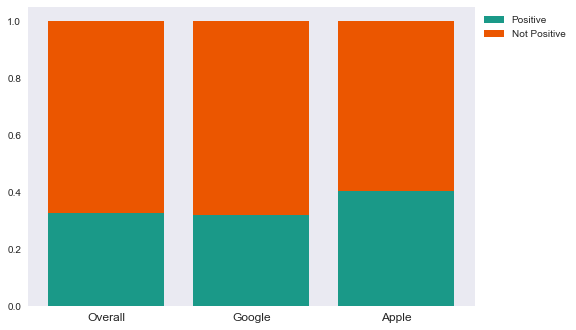

In [366]:
# Create stack bars showing sentiment by Brand

brand_summary = pd.DataFrame([overall_vc, google_vc, apple_vc], index=['Overall', 'Google', 'Apple'])

fig, ax = plt.subplots()

labels = ['Overall', 'Google', 'Apple']
positive = list(brand_summary.iloc[:,1])
not_positive = list(brand_summary.iloc[:,0])

ax.bar(labels, positive, label='Positive', color=('#1a9988'))
ax.bar(labels, not_positive, label='Not Positive', bottom=positive, color=('#eb5600'))
ax.set_xticklabels(labels, fontsize=12)
ax.legend(bbox_to_anchor=(1,1))
plt.grid(False);

In [265]:
# Grab a sensible exampe to use as a demonstration of a clean tweet

df_clean.iloc[34:35,:]

,tweet,product/company,emotion,brand,clean_tweet,sentiment,clean_tweet_stem,tokens,sentiment_type
35,"At #sxsw. Oooh. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link}",NaN,No emotion toward brand or product,Google,oooh rt google launch major new social network called circles possibly today,0,oooh rt googl launch major new social network call circl possibl today,"[oooh, rt, google, launch, major, new, social, network, called, circles, possibly, today]",Not Positive


In [266]:
# Find length of the tweets before and after cleaning
# The tweets originally had an average character length of 105. After cleaning, this was reduced to 63.

df_clean['original_length'] = df_clean['tweet'].apply(lambda x: len(x))
df_clean['new_length'] = df_clean['clean_tweet'].apply(lambda x: len(x))

df_clean.describe()

,sentiment,original_length,new_length
count,9065.000000,9065.000000,9065.000000
mean,0.327413,104.969333,63.438058
std,0.469295,27.191156,20.817683
min,0.000000,11.000000,2.000000
25%,0.000000,86.000000,49.000000
50%,0.000000,109.000000,64.000000
75%,1.000000,126.000000,78.000000
max,1.000000,178.000000,188.000000


In [325]:
# Sample positive Google tweets to include in the presentation

google_pos[['tweet', 'clean_tweet']].iloc[30:40,:]

,tweet,clean_tweet
333,"ÛÏ@mention At Google, 4 people do the work of 7 people rather than 7 people doing the work of 4. #agileagency #SXSWÛ", google 4 people work 7 people rather 7 people work 4 agileagency  
337,First day at sxsw. Fun final presentation on Google Doodles. #GoogleDoodle #sxsw,first day fun final presentation google doodles googledoodle
339,If ur not at the #google #aclu 80's party....u should be! #sxsw,ur google aclu 80 party ... u
374,Of course Bing results are good they are Google's:) #SEO #SXSW #qagb,course bing results good google's :) seo qagb
386,&quot;You can Google Canadian Tuxedo and lose yourself for hours&quot; #sxsw,google canadian tuxedo lose hours
390,Dont miss Charles Chen for Android/ChromeOS Access at SXSW: @mention the Google booth in Exhibit Hall 3 @mention 1PM #sxsw,dont miss charles chen android chromeos access google booth exhibit hall 3 1pm
428,Google TV demo at the league for extraordinary hackers. Cool stuff! I like Web apps on TV. #google #sxsw #lxh,google tv demo league extraordinary hackers cool stuff like web apps tv google lxh
443,We really DO need another big social network right now - thanks! #SXSW #Google {link},really need another big social network right thanks google
482,Badgeless event! Free Drinks! ÛÏ@mention Heading to free Google-sponsored happy hour for Semantic Web Austin @mention Fogo de ChÌÁo #sxswÛ,badgeless event free drinks  heading free google-sponsored happy hour semantic web austin fogo de chìáo  
492,One of my fav photos of #SXSW so far @mention &amp; @mention #google #SXSW {link},one fav photos far google


In [347]:
# Sample negative Google tweets to include in the presentation

google_neg[['tweet', 'clean_tweet']].iloc[250:260,:]

,tweet,clean_tweet
1250,"So we get to see google fail at social on another day RT @mention Okay, no Google Circles debuting at #sxsw today",get see google fail social another day rt okay google circles debuting today
1252,"Listening to some Google marketers speak. Based on the crowd and what they're all holding, Steve Jobs is wealthier than I thought. #SXSW",listening google marketers speak based crowd they're holding steve jobs wealthier thought
1253,Google vp to speak. The topic: 10 quick steps to owning everything in the world. #sxsw {link},google vp speak topic 10 quick steps owning everything world
1266,Social Is Too Important For #Google To Screw Up With A Big Launch Circus {link} #socialmedia #sxsw,social important google screw big launch circus socialmedia
1267,Social Is Too Important For Google To Screw Up With A Big Launch Circus. #sxsw Via @mention {link},social important google screw big launch circus via
1269,#futuremf Trajan: Google has destroyed the &lt;title&gt; tag - websites SEO them. Open Graph Protocol added a clean title tag instead #sxsw,futuremf trajan google destroyed <title> tag websites seo open graph protocol added clean title tag instead
1280,Google to unveil new social platform Circles that groups peeps by relevance #Sxsw,google unveil new social platform circles groups peeps relevance
1290,is anyone using google checkins thru latitude? #sxsw,anyone using google checkins thru latitude
1297,This Waze vs Google discussion is one of the best I have seen at #sxsw. We need more competitors going head to head here.,waze vs google discussion one best seen need competitors going head head
1298,Dense una vuelta por #socialfuel #sxsw para ver la gran diferencia..RT @mention &quot;The revolution will be clumsily translated by Google.&quot;,dense una vuelta por socialfuel para ver la gran diferencia .. rt revolution clumsily translated google


## Baseline Understanding

- Our baseline model would predict the majority class (Tweet is not positive) every time
- This would lead to an accuracy of 67%

In [97]:
df_clean['sentiment'].value_counts(normalize=True)

0    0.672587
1    0.327413
Name: sentiment, dtype: float64

## Modeling

We will take an initial modeling approach that evaluates 20 models.
- Model types:
    - SVM: Support Vector Machines can be a powerful text classification tool when the number of texts is reasonably small. Since we only have a few thousand tweets in our train set, this might be a good approach.
    - Bayes: the classic text classification algorithm. Very fast and generally well suited to these tasks.
    - Random Forest: Generally more accurate than a simple decision tree, this could perform well for text classification
    - Logistic Regression: the "simplest" model type.
    - XGBoost: We wanted to include at least one boosting algorithm given how well they generally perform in classification tasks
- Model permutations: for each model type, four models will be trained:
    - Using Stemmatization vs. no Stemmatization: Stemming or Lemmatizing may not be appropriate for tweets given that it's a less formal medium and people misspell words that may make proper Stemming difficult. However, we will still test whether Stemming improves model performance.
    - Count Vectorizer vs. TD-IDF: We will also test with using a Count Vecotrizer vs. TF-IDF vectorizer improves model performance
- We will then choose the best performing "base" model and do hyperparameter tuning to try to improve the accuracy even further.

### Model Evaluation
- Models will be evaluated based on accuracy, recall, precision, and F1 as well as a printed confusion matrix
- We will aim to reduce False Positives (predicting a tweet is positive when it is in fact negative). We would rather be conservative and not incorrectly say that a brand or product is doing well vs. striving to improve the existing product set.

### Modeling without stemmatizing

In [55]:
# Define our X and y
X = df_clean['clean_tweet']
y = df_clean['sentiment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [59]:
# Create CountVectorizer

ct_vectorizer = CountVectorizer()  

ct_vectorizer.fit(X_train)

X_train_ctvec = cv_vectorizer.transform(X_train)
X_test_ctvec = cv_vectorizer.transform(X_test)

In [60]:
# Create TF-IDF Vectorizer

tf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.05)

tf_vectorizer.fit(X_train)

X_train_tfvec = tf_vectorizer.transform(X_train)
X_test_tfvec = tf_vectorizer.transform(X_test)

In [83]:
# Create dataframe to store the results

index = ['svm_ct', 'svm_tf', 'bayes_ct', 'bayes_tf', 'rf_ct', 'rf_tf', 'log_reg_ct', 'log_reg_tf', 
         'boost_ct', 'boost_tf']
cols = ['Accuracy', 'Precision', 'Recall', 'F1']

df_results = pd.DataFrame(index=index, columns=cols)

### SVM

Train results
Accuracy: 0.8932
Precision: 0.9014
Recall: 0.8932
F1 Score: 0.8882
ROC: 0.9736

Test results
Accuracy: 0.7486
Precision: 0.7418
Recall: 0.7486
F1 Score: 0.7195
ROC: 0.7801



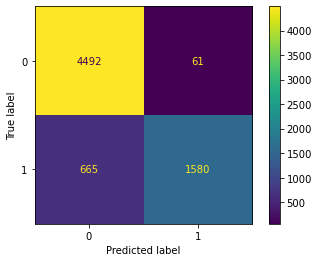

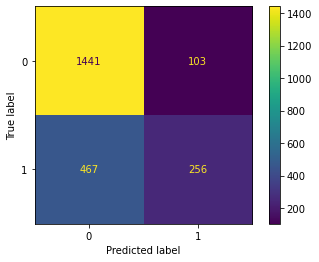

In [86]:
# Using count vectorizer

svm_ct = SVC(random_state=42)

svm_ct.fit(X_train_ctvec, y_train)


for i, item in enumerate([(X_train_ctvec, y_train), (X_test_ctvec, y_test)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(svm_ct, item[0], item[1], plot_cf=True)
    print('')
    
df_results.iloc[0,:] = [acc, prec, recall, f1]

Train results
Accuracy: 0.6833
Precision: 0.6545
Recall: 0.6833
F1 Score: 0.6179
ROC: 0.5793

Test results
Accuracy: 0.6850
Precision: 0.6436
Recall: 0.6850
F1 Score: 0.6156
ROC: 0.5558



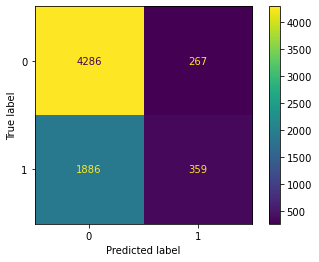

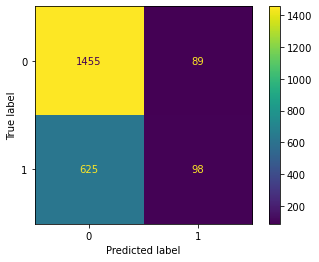

In [87]:
# Using TF-IDF vectorizer

svm_tf = SVC(random_state=42)

svm_tf.fit(X_train_tfvec, y_train)


for i, item in enumerate([(X_train_tfvec, y_train), (X_test_tfvec, y_test)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(svm_tf, item[0], item[1], plot_cf=True)
    print('')
    
df_results.iloc[1,:] = [acc, prec, recall, f1]

### Bayes

Train results
Accuracy: 0.8635
Precision: 0.8620
Recall: 0.8635
F1 Score: 0.8623
ROC: nan

Test results
Accuracy: 0.7195
Precision: 0.7107
Recall: 0.7195
F1 Score: 0.7137
ROC: nan



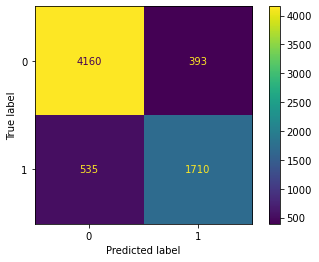

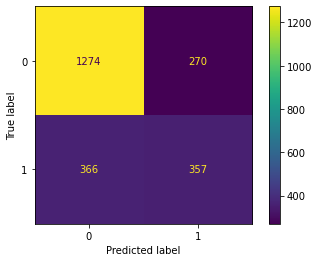

In [88]:
# Bayes on count vectorizer

bayes_ct = MultinomialNB()

bayes_ct.fit(X_train_ctvec, y_train)

for i, item in enumerate([(X_train_ctvec, y_train), (X_test_ctvec, y_test)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(bayes_ct, item[0], item[1], plot_cf=True)
    print('')
    
df_results.iloc[2,:] = [acc, prec, recall, f1]

Train results
Accuracy: 0.6696
Precision: 0.4485
Recall: 0.6696
F1 Score: 0.5372
ROC: nan

Test results
Accuracy: 0.6806
Precision: 0.4638
Recall: 0.6806
F1 Score: 0.5517
ROC: nan



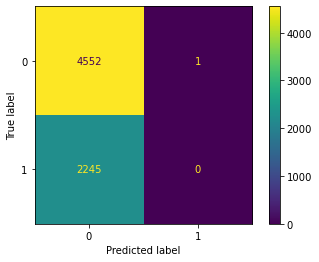

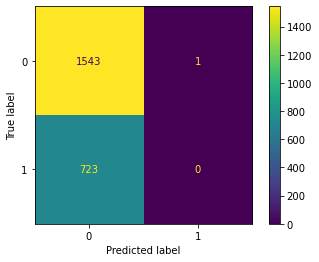

In [89]:
# Bayes on TF-IDF vectorizer

bayes_tf = MultinomialNB()

bayes_tf.fit(X_train_tfvec, y_train)

for i, item in enumerate([(X_train_tfvec, y_train), (X_test_tfvec, y_test)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(bayes_tf, item[0], item[1], plot_cf=True)
    print('')
    
df_results.iloc[3,:] = [acc, prec, recall, f1]

### Random Forest

Train results
Accuracy: 0.9912
Precision: 0.9912
Recall: 0.9912
F1 Score: 0.9912
ROC: nan

Test results
Accuracy: 0.7393
Precision: 0.7254
Recall: 0.7393
F1 Score: 0.7200
ROC: nan



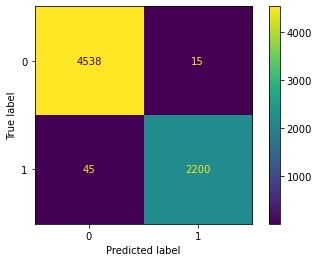

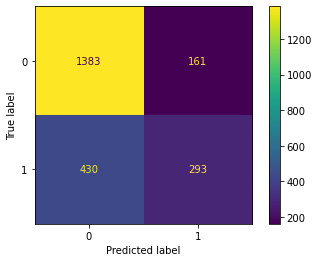

In [90]:
# RF on count vectorizer

rf_ct = RandomForestClassifier(random_state=42)

rf_ct.fit(X_train_ctvec, y_train)

for i, item in enumerate([(X_train_ctvec, y_train), (X_test_ctvec, y_test)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(rf_ct, item[0], item[1], plot_cf=True)
    print('')
    
df_results.iloc[4,:] = [acc, prec, recall, f1]

Train results
Accuracy: 0.7067
Precision: 0.6912
Recall: 0.7067
F1 Score: 0.6632
ROC: nan

Test results
Accuracy: 0.6767
Precision: 0.6307
Recall: 0.6767
F1 Score: 0.6200
ROC: nan



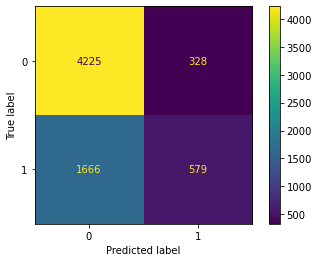

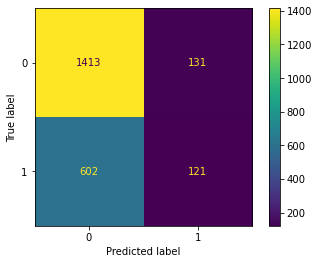

In [91]:
# RF on tf-idf vectorizer

rf_tf = RandomForestClassifier(random_state=42)

rf_tf.fit(X_train_tfvec, y_train)

for i, item in enumerate([(X_train_tfvec, y_train), (X_test_tfvec, y_test)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(rf_tf, item[0], item[1], plot_cf=True)
    print('')
    
df_results.iloc[5,:] = [acc, prec, recall, f1]

### Logistic regression

Train results
Accuracy: 0.8960
Precision: 0.8980
Recall: 0.8960
F1 Score: 0.8930
ROC: 0.9622

Test results
Accuracy: 0.7450
Precision: 0.7328
Recall: 0.7450
F1 Score: 0.7323
ROC: 0.7589



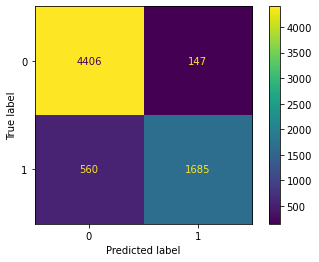

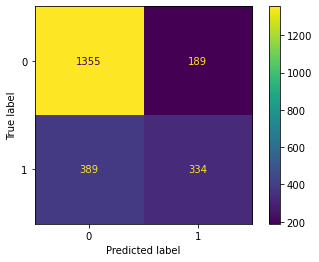

In [92]:
# Using count vectorizer

log_reg_ct = LogisticRegression(random_state=42, max_iter=10000)

log_reg_ct.fit(X_train_ctvec, y_train)


for i, item in enumerate([(X_train_ctvec, y_train), (X_test_ctvec, y_test)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(log_reg_ct, item[0], item[1], plot_cf=True)
    print('')
    
df_results.iloc[6,:] = [acc, prec, recall, f1]

Train results
Accuracy: 0.6721
Precision: 0.6282
Recall: 0.6721
F1 Score: 0.5812
ROC: 0.6357

Test results
Accuracy: 0.6837
Precision: 0.6396
Recall: 0.6837
F1 Score: 0.5900
ROC: 0.6448



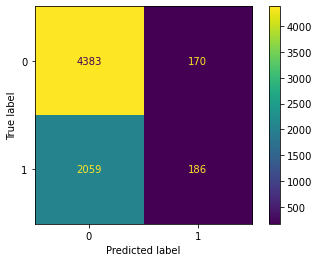

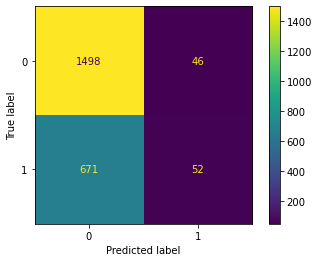

In [93]:
# Using TF-IDF Vectorizer

log_reg_tf = LogisticRegression(random_state=42, max_iter=10000)

log_reg_tf.fit(X_train_tfvec, y_train)


for i, item in enumerate([(X_train_tfvec, y_train), (X_test_tfvec, y_test)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(log_reg_tf, item[0], item[1], plot_cf=True)
    print('')
    
df_results.iloc[7,:] = [acc, prec, recall, f1]

### XG Boost

Train results
Accuracy: 0.8061
Precision: 0.8195
Recall: 0.8061
F1 Score: 0.7873
ROC: nan

Test results
Accuracy: 0.7411
Precision: 0.7316
Recall: 0.7411
F1 Score: 0.7105
ROC: nan



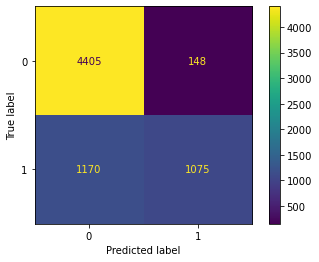

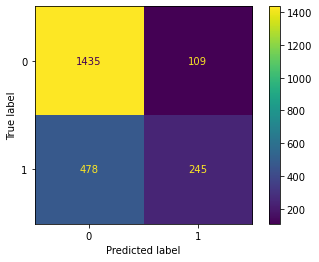

In [94]:
# Gradient Booster on count vectorizer

boost_ct = XGBClassifier(random_state=42)

boost_ct.fit(X_train_ctvec, y_train)

for i, item in enumerate([(X_train_ctvec, y_train), (X_test_ctvec, y_test)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(boost_ct, item[0], item[1], plot_cf=True)
    print('')
    
df_results.iloc[8,:] = [acc, prec, recall, f1]

Train results
Accuracy: 0.7055
Precision: 0.6900
Recall: 0.7055
F1 Score: 0.6602
ROC: nan

Test results
Accuracy: 0.6789
Precision: 0.6345
Recall: 0.6789
F1 Score: 0.6219
ROC: nan



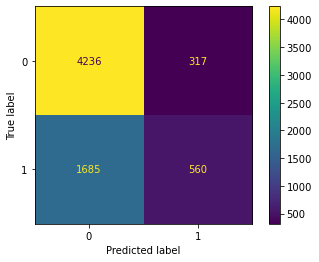

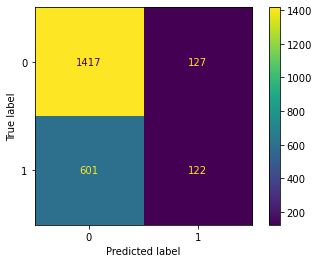

In [95]:
# Gradient Booster on tf-idf vectorizer

boost_tf = XGBClassifier(random_state=42)

boost_tf.fit(X_train_tfvec, y_train)

for i, item in enumerate([(X_train_tfvec, y_train), (X_test_tfvec, y_test)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(boost_tf, item[0], item[1], plot_cf=True)
    print('')
    
df_results.iloc[9,:] = [acc, prec, recall, f1]

### Modeling: using stemming

- We opted for Stemming vs. Lemmatization given the nature of tweets. If people are already fairly loose with spelling, our hypothesis is that we may lose more predictive value when using lemmatization

In [100]:
stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(document)
    stemed_text = [stemmer.stem(token) for token in tokens]
    clean_text = " ".join(stemed_text)    
    return clean_text

In [101]:
df_clean['clean_tweet_stem'] = df_clean['clean_tweet'].apply(lambda x: stem_and_tokenize(x))

In [103]:
# Test train split

X2 = df_clean['clean_tweet_stem']
y2 = df_clean['sentiment']

# Split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.25, random_state=42)

In [104]:
# Create CountVectorizer

ct_vectorizer2 = CountVectorizer()  

ct_vectorizer2.fit(X_train2)

X_train_ctvec_stem = ct_vectorizer2.transform(X_train2)
X_test_ctvec_stem = ct_vectorizer2.transform(X_test2)

In [105]:
# Create TF-IDF Vectorizer

tf_vectorizer2 = TfidfVectorizer(max_df=0.95, min_df=0.05)

tf_vectorizer2.fit(X_train2)

X_train_tfvec_stem = tf_vectorizer2.transform(X_train2)
X_test_tfvec_stem = tf_vectorizer2.transform(X_test2)

In [106]:
# Create dataframe to store the Stemmed results

index = ['svm_ct', 'svm_tf', 'bayes_ct', 'bayes_tf', 'rf_ct', 'rf_tf', 'log_reg_ct',
         'log_reg_tf', 'boost_ct', 'boost_tf']

cols = ['Accuracy', 'Precision', 'Recall', 'F1']

df_results_stem = pd.DataFrame(index=index, columns=cols)

### SVM - stemmed

Train results
Accuracy: 0.8867
Precision: 0.8960
Recall: 0.8867
F1 Score: 0.8810
ROC: 0.9701

Test results
Accuracy: 0.7534
Precision: 0.7510
Recall: 0.7534
F1 Score: 0.7226
ROC: 0.7812



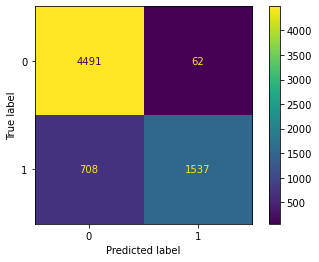

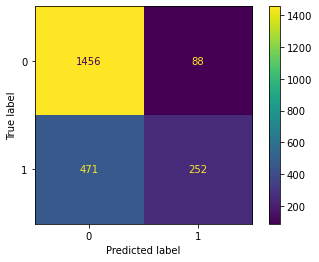

In [107]:
# SVM model with count vectorization

svm_ct = SVC(random_state=42)
svm_ct.fit(X_train_ctvec_stem, y_train2)

for i, item in enumerate([(X_train_ctvec_stem, y_train2), (X_test_ctvec_stem, y_test2)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(svm_ct, item[0], item[1], plot_cf=True)
    print('')
    
df_results_stem.iloc[0,:] = [acc, prec, recall, f1]

Train results
Accuracy: 0.6873
Precision: 0.6665
Recall: 0.6873
F1 Score: 0.6158
ROC: 0.6355

Test results
Accuracy: 0.6820
Precision: 0.6347
Recall: 0.6820
F1 Score: 0.6035
ROC: 0.5904



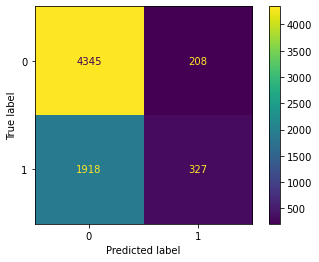

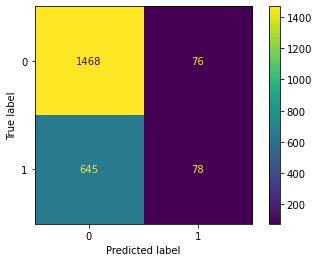

In [111]:
# SVM model with TF-IDF vectorization

svm_tf = SVC(random_state=42)
svm_tf.fit(X_train_tfvec_stem, y_train2)

for i, item in enumerate([(X_train_tfvec_stem, y_train2), (X_test_tfvec_stem, y_test2)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(svm_tf, item[0], item[1], plot_cf=True)
    print('')
    
df_results_stem.iloc[1,:] = [acc, prec, recall, f1]

### Bayes - Stemmed

Train results
Accuracy: 0.8441
Precision: 0.8424
Recall: 0.8441
F1 Score: 0.8430
ROC: nan

Test results
Accuracy: 0.7075
Precision: 0.6997
Recall: 0.7075
F1 Score: 0.7027
ROC: nan



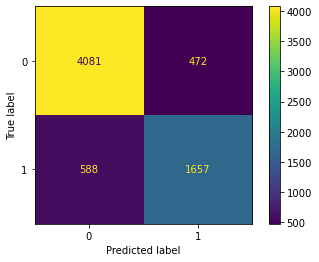

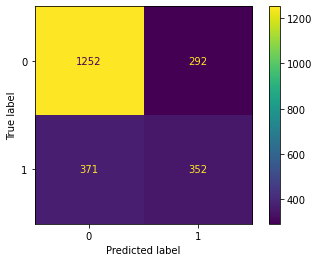

In [115]:
# Bayes model with count vectorization

bayes_ct = MultinomialNB()
bayes_ct.fit(X_train_ctvec_stem, y_train2)

for i, item in enumerate([(X_train_ctvec_stem, y_train2), (X_test_ctvec_stem, y_test2)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(bayes_ct, item[0], item[1], plot_cf=True)
    print('')
    
df_results_stem.iloc[2,:] = [acc, prec, recall, f1]

Train results
Accuracy: 0.6698
Precision: 0.4486
Recall: 0.6698
F1 Score: 0.5373
ROC: nan

Test results
Accuracy: 0.6811
Precision: 0.4639
Recall: 0.6811
F1 Score: 0.5519
ROC: nan



/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


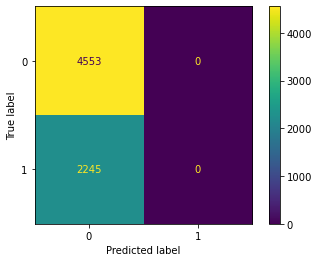

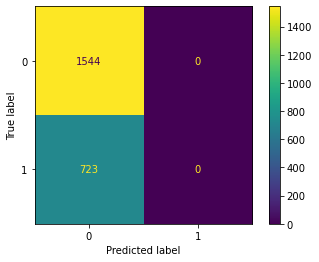

In [123]:
# Bayes model with TF-IDF vectorization

bayes_tf = MultinomialNB()
bayes_tf.fit(X_train_tfvec_stem, y_train2)

for i, item in enumerate([(X_train_tfvec_stem, y_train2), (X_test_tfvec_stem, y_test2)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(bayes_tf, item[0], item[1], plot_cf=True)
    print('')
    
df_results_stem.iloc[3,:] = [acc, prec, recall, f1]

### Random Forest - Stemmed

Train results
Accuracy: 0.9910
Precision: 0.9910
Recall: 0.9910
F1 Score: 0.9910
ROC: nan

Test results
Accuracy: 0.7397
Precision: 0.7259
Recall: 0.7397
F1 Score: 0.7203
ROC: nan



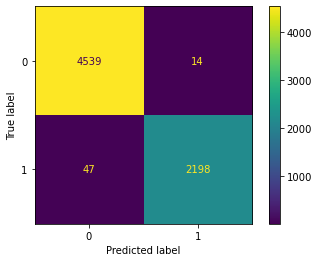

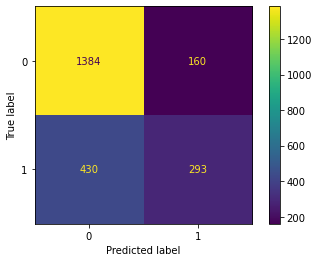

In [119]:
# Random Forest model with count vectorization

rf_ct = RandomForestClassifier(random_state=42)
rf_ct.fit(X_train_ctvec_stem, y_train2)

for i, item in enumerate([(X_train_ctvec_stem, y_train2), (X_test_ctvec_stem, y_test2)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(rf_ct, item[0], item[1], plot_cf=True)
    print('')
    
df_results_stem.iloc[4,:] = [acc, prec, recall, f1]

Train results
Accuracy: 0.7199
Precision: 0.7135
Recall: 0.7199
F1 Score: 0.6775
ROC: nan

Test results
Accuracy: 0.6700
Precision: 0.6206
Recall: 0.6700
F1 Score: 0.6153
ROC: nan



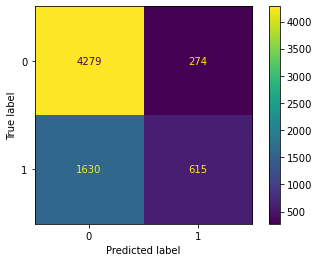

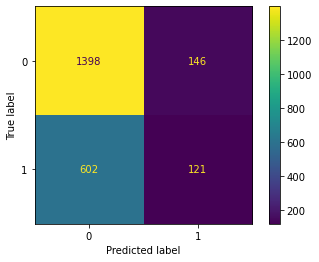

In [121]:
# Random Forest model with TF-IDF vectorization

rf_tf = RandomForestClassifier(random_state=42)
rf_tf.fit(X_train_tfvec_stem, y_train2)

for i, item in enumerate([(X_train_tfvec_stem, y_train2), (X_test_tfvec_stem, y_test2)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(rf_tf, item[0], item[1], plot_cf=True)
    print('')
    
df_results_stem.iloc[5,:] = [acc, prec, recall, f1]

### Log Reg - Stemmed

Train results
Accuracy: 0.8742
Precision: 0.8759
Recall: 0.8742
F1 Score: 0.8700
ROC: 0.9490

Test results
Accuracy: 0.7499
Precision: 0.7383
Recall: 0.7499
F1 Score: 0.7373
ROC: 0.7573



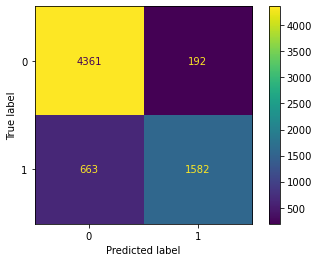

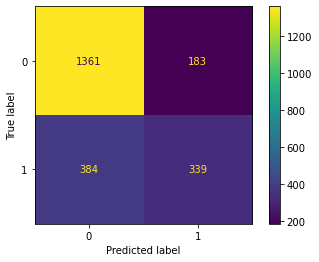

In [124]:
# Logistic Regression with count vectorization

log_reg_ct = LogisticRegression(max_iter=10000, random_state=42)
log_reg_ct.fit(X_train_ctvec_stem, y_train2)

for i, item in enumerate([(X_train_ctvec_stem, y_train2), (X_test_ctvec_stem, y_test2)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(log_reg_ct, item[0], item[1], plot_cf=True)
    print('')
    
df_results_stem.iloc[6,:] = [acc, prec, recall, f1]

Train results
Accuracy: 0.6706
Precision: 0.6234
Recall: 0.6706
F1 Score: 0.5822
ROC: 0.6393

Test results
Accuracy: 0.6793
Precision: 0.6238
Recall: 0.6793
F1 Score: 0.5896
ROC: 0.6401



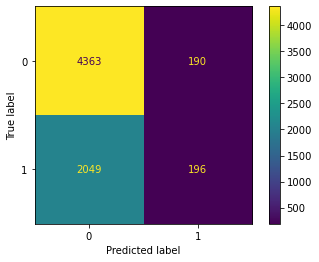

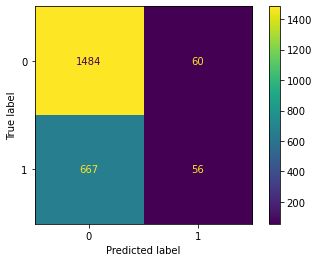

In [125]:
# Logistic Regression with TF-IDF vectorization

log_reg_tf = LogisticRegression(max_iter=10000, random_state=42)
log_reg_tf.fit(X_train_tfvec_stem, y_train2)

for i, item in enumerate([(X_train_tfvec_stem, y_train2), (X_test_tfvec_stem, y_test2)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(log_reg_tf, item[0], item[1], plot_cf=True)
    print('')
    
df_results_stem.iloc[7,:] = [acc, prec, recall, f1]

### XG Boost - Stemmed

Train results
Accuracy: 0.8110
Precision: 0.8243
Recall: 0.8110
F1 Score: 0.7933
ROC: nan

Test results
Accuracy: 0.7543
Precision: 0.7480
Recall: 0.7543
F1 Score: 0.7282
ROC: nan



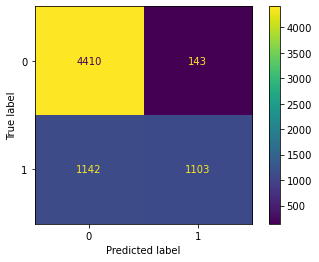

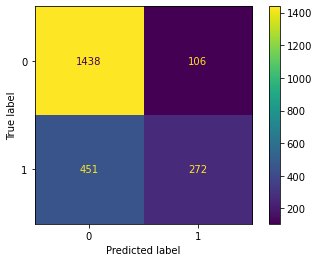

In [127]:
# XGBoost with count vectorization

boost_ct = XGBClassifier(random_state=42)
boost_ct.fit(X_train_ctvec_stem, y_train2)

for i, item in enumerate([(X_train_ctvec_stem, y_train2), (X_test_ctvec_stem, y_test2)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(boost_ct, item[0], item[1], plot_cf=True)
    print('')
    
df_results_stem.iloc[8,:] = [acc, prec, recall, f1]

Train results
Accuracy: 0.7183
Precision: 0.7136
Recall: 0.7183
F1 Score: 0.6725
ROC: nan

Test results
Accuracy: 0.6709
Precision: 0.6209
Recall: 0.6709
F1 Score: 0.6143
ROC: nan



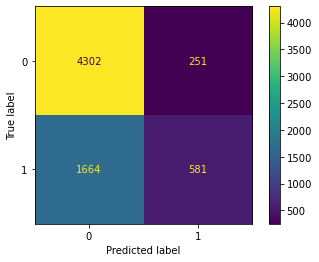

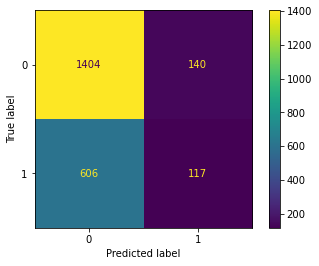

In [128]:
# XGBoost with TF-IDF vectorization

boost_tf = XGBClassifier(random_state=42)
boost_tf.fit(X_train_tfvec_stem, y_train2)

for i, item in enumerate([(X_train_tfvec_stem, y_train2), (X_test_tfvec_stem, y_test2)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(boost_tf, item[0], item[1], plot_cf=True)
    print('')
    
df_results_stem.iloc[9,:] = [acc, prec, recall, f1]

## Evaluation: no Stemming

For the models that did not use Stemming, we have the following results:
- Generally 70-75% accuracy
- SVM has performed the best on the testing set, and has a nice balance of precision and recall
- Surprisingly, the logistic regression is a close second and almost performs as well as SVM
- The simple count vectorizer consistently outperforms the TF-IDF vectorizer
- Upon further examination of TF-IDF, it performs very poorly on Tweet data given the non-standard language used, particularly if you cut it off at the 95% and 5% threshold like we did. We will likely need to do a lot more cleaning to make this approach feasible.
- Also, there is likely high multi-collinearity among the data, which is relevant for the Logistic Regression. We are not using that for the final model, but a next step could be applying PCA to see if that improves the Log Reg results

In [98]:
# Print results
df_results

,Accuracy,Precision,Recall,F1
svm_ct,0.748566,0.741799,0.745037,0.71953
svm_tf,0.685046,0.643562,0.745037,0.615582
bayes_ct,0.719453,0.710668,0.745037,0.713707
bayes_tf,0.680635,0.463769,0.745037,0.551654
rf_ct,0.739303,0.725367,0.745037,0.719957
rf_tf,0.676665,0.630732,0.745037,0.619963
log_reg_ct,0.745037,0.732834,0.745037,0.732329
log_reg_tf,0.683723,0.639604,0.745037,0.589956
boost_ct,0.741067,0.73162,0.745037,0.710529
boost_tf,0.678871,0.634498,0.745037,0.621937


## Evaluation: Stemming

- The Stemmed data seemed to perform slightly better than the unstemmed data.
- Again, TF-IDF vectorization doesn't seem suitable for our data given how we've set it up.
- SVM and XGBoost performed almost identically on the test data
- Logistic regression was a close third
- No other model type performed particularly well

In [130]:
# Print results
df_results_stem

,Accuracy,Precision,Recall,F1
svm_ct,0.753419,0.750985,0.745037,0.722601
svm_tf,0.681959,0.634708,0.745037,0.603528
bayes_ct,0.707543,0.699708,0.745037,0.70274
bayes_tf,0.681076,0.463865,0.745037,0.551867
rf_ct,0.739744,0.72591,0.745037,0.720331
rf_tf,0.670049,0.620603,0.745037,0.615287
log_reg_ct,0.74989,0.738318,0.745037,0.737343
log_reg_tf,0.679312,0.623846,0.745037,0.589647
boost_ct,0.754301,0.747959,0.745037,0.728152
boost_tf,0.670931,0.620928,0.745037,0.614267


### Final model tuning

- SVM and XGBoost have performed similarly well on the test data.
- We will run a grid search on each to do a final evaluation and determine our "best" model

#### XGBoost Tuning

In [131]:
# XGBoost Grid Search

xgb_clf = XGBClassifier(random_state=42)

xgb_param_grid = {
'learning_rate': [0.001, 0.01, 0.1],
'n_estimators': [10, 100, 1000],
'subsample': [0.3, 0.5, 0.7],
'max_depth': [3, 5, 7, 9, 11, 15]
}

In [132]:
# Perform the grid search

# xgb_grid_search = GridSearchCV(xgb_clf, xgb_param_grid, return_train_score=True, cv=5)

# xgb_grid_search.fit(X_train_ctvec_stem, y_train2)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, v

In [133]:
xgb_grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 1000, 'subsample': 0.7}

Train results
Accuracy: 0.7892
Precision: 0.8039
Recall: 0.7892
F1 Score: 0.7655
ROC: nan

Test results
Accuracy: 0.7499
Precision: 0.7453
Recall: 0.7499
F1 Score: 0.7191
ROC: nan



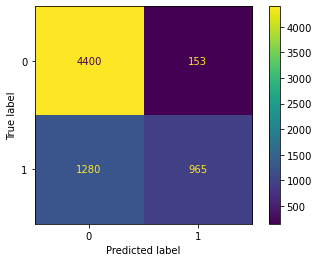

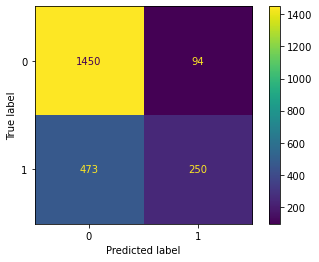

In [135]:
# Run model using hte best parameters

xbg_best_params = XGBClassifier(learning_rate=0.01, max_depth=9, n_estimators=1000, subsample=0.7, random_state = 15)
xbg_best_params.fit(X_train_ctvec_stem, y_train2)

for i, item in enumerate([(X_train_ctvec_stem, y_train2), (X_test_ctvec_stem, y_test2)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(xbg_best_params, item[0], item[1], plot_cf=True)
    print('')

#### SVM Tuning

In [140]:
svm_param_grid = {'C': [0.1,1, 10, 100], 'class_weight': ['balanced', None], 'kernel': ['rbf', 'sigmoid']}

svm_clf = SVC(random_state=15)

tuned_svm = GridSearchCV(svm_clf, param_grid=svm_param_grid, return_train_score=True, cv=5)

tuned_svm.fit(X_train_ctvec_stem, y_train2)

GridSearchCV(cv=5, estimator=SVC(random_state=15),
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'kernel': ['rbf', 'sigmoid']},
             return_train_score=True)

In [141]:
tuned_svm.best_params_

{'C': 1, 'class_weight': None, 'kernel': 'rbf'}

Train results
Accuracy: 0.8867
Precision: 0.8960
Recall: 0.8867
F1 Score: 0.8810
ROC: 0.9701

Test results
Accuracy: 0.7534
Precision: 0.7510
Recall: 0.7534
F1 Score: 0.7226
ROC: 0.7812



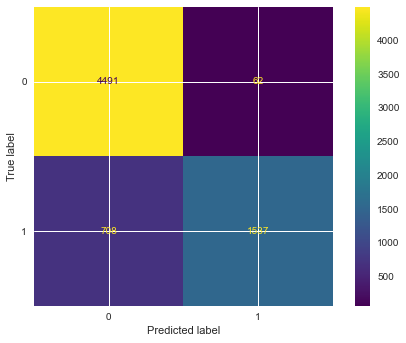

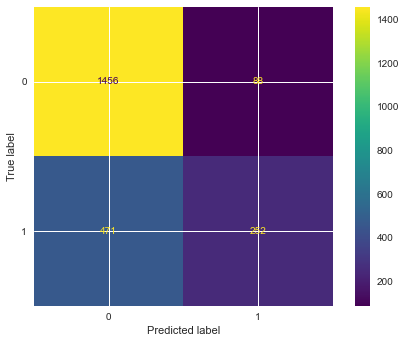

In [199]:
# Run SVM with best params

svm_best_params = SVC(random_state = 15, C=1, class_weight=None, kernel='rbf')
svm_best_params.fit(X_train_ctvec_stem, y_train2)

for i, item in enumerate([(X_train_ctvec_stem, y_train2), (X_test_ctvec_stem, y_test2)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(svm_best_params, item[0], item[1], plot_cf=True)
    print('')

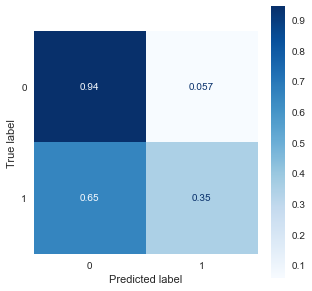

In [308]:
# Plot better confusion matrix

fig, ax = plt.subplots(figsize=(5,5))
ax.grid(False)

plot_confusion_matrix(svm_best_params, X_test_ctvec_stem, y_test2, ax=ax, normalize='true', 
                      include_values=True, cmap='Blues');

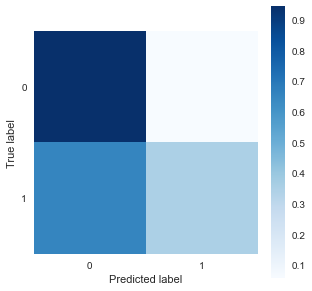

In [311]:
# Plot better confusion matrix

fig, ax = plt.subplots(figsize=(5,5))
ax.grid(False)

plot_confusion_matrix(svm_best_params, X_test_ctvec_stem, y_test2, ax=ax, normalize='true', 
                      include_values=False, cmap='Blues');

### 'Final' Model

- Our final model is the SVM with tuned parameters.
- This also minimizes False Positives in line with our business problem
- Model interpretability with SVM is tricky, but our deliverable is the model itself so this isn't a concern.
- If our tweet dataset continues to expand, SVM may perform performly with more dimensions

Train results
Accuracy: 0.8867
Precision: 0.8960
Recall: 0.8867
F1 Score: 0.8810
ROC: 0.9701

Test results
Accuracy: 0.7534
Precision: 0.7510
Recall: 0.7534
F1 Score: 0.7226
ROC: 0.7812



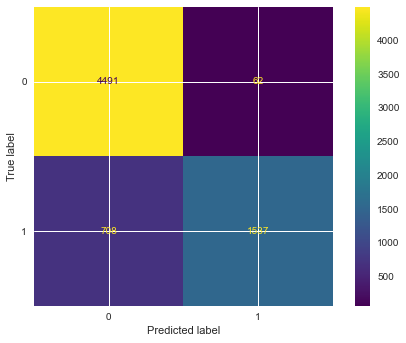

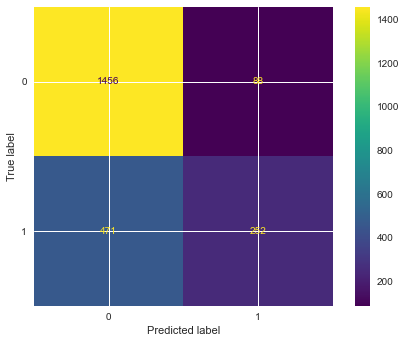

In [369]:
final_model = svm_best_params

final_model = SVC(random_state = 15, C=1, class_weight=None, kernel='rbf')
final_model.fit(X_train_ctvec_stem, y_train2)

for i, item in enumerate([(X_train_ctvec_stem, y_train2), (X_test_ctvec_stem, y_test2)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(final_model, item[0], item[1], plot_cf=True)
    print('')

## Conclusions

With basic cleaning steps and testing a variety of models, we were able to improve model accuracy materially above baseline. 67% -> 75%.

- Our recommendation is that this model can be used to track brand sentiment at future tech events similar to SXSW
- The model, along with word freq distributions, can serve as an "early warning" system for potential brand issues, e.g., Google Circles / Google+

Next steps:
- There are almost too many next steps to list here.
- Tweets are messy, and there is likely substantially more cleaning that can be performed on them.
- Additional feature engineering can be useful too, such as exploring Bigrams and Word2Vec (the value of these approaches increases the cleaner the data gets)
- Additionally, the model can continue to be tuned with additional tweets from other past conferences

Final Model:
- While SVM did perform the best and produced the best split of False Positive to False Negative, the model may perform worse at more tweets from future events are added to tune the model.
- SVM runs more slowly as you increase dimensions, so at a certain point, it may make sense to revert back to XGBoost or other models that are better equipped to handle high dimensionality (e.g., Naive Bayes)
